<h1><center>
Analysis of Lending Club Dataset Using Logistic Regression
    </center></h1>

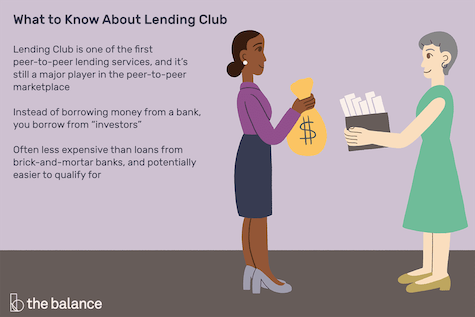

Lending Clun is a peer-to-peer lending company. Borrowers can get unsecure loans ranging from $1,000 to $40,000. Borrowers have a term of either 36 months to 60 months to pay it back and they usually pay at lower interest rates than if they were borrowing from the bank.
The dataset used in this Kernel was obtained from https://www.kaggle.com/wendykan/lending-club-loan-data and it contains information from 2007 to 2015.
In this exercise, I am going to predict if lenders have paid back their debts or not. 

In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import WOEEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the data into a dataframe and checking the first 5 rows
df = pd.read_csv('loan.csv')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# checking the shape of the dataframe. It has over 2 million rows and 145 cols
df.shape

(2260668, 145)

In [4]:
# These are the types of data in my dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [5]:
# Checking the first 15 columns and I decided to drop columns: id, member_id and url since I dont need this information for the analysis.
#I checked the other columns as well and for now I decided to keep them
df.iloc[:,0:15].head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified


In [6]:
df.drop(columns=['id','member_id', 'url'], inplace=True)

In [7]:
# Finding the index of my target column
df.columns.get_loc("loan_status")

14

In [8]:
# Identifying all the unique values for my target variable.
# My goal was to turn this problem into a yes/no problem.
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [9]:
#since I want to predict whether or not a loan was completely paid I am going to drop loans with status = current, grace period, late and the ones that do not meet the credit policy.
i = df[((df.loan_status == 'Current') | (df.loan_status == 'Late (31-120 days)') | (df.loan_status == 'In Grace Period') | (df.loan_status == 'Late (16-30 days)') | (df.loan_status == 'Late (16-30 days)') | (df.loan_status == 'Default'))].index

In [10]:
df.drop(index=i, inplace=True)

In [11]:
df.shape

(1306356, 142)

In [12]:
i = df[((df.loan_status == 'Does not meet the credit policy. Status:Charged Off') | (df.loan_status == 'Does not meet the credit policy. Status:Fully Paid') )].index

In [13]:
df.drop(index=i, inplace=True)

In [14]:
# This is the final shape of my dataframe alfter dropping all the targets that I am not interested for this analysis.
df.shape

(1303607, 142)

In [15]:
# checking to see that I only have two variables into 
df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [16]:
encoder = LabelEncoder()

In [17]:
# encoding my target variable. So loans that have been paid will get a value of 1 and the ones that haven't will have a value of zero.
df['loan_status'] = encoder.fit_transform(df.loan_status.values)

In [18]:
df.iloc[:,0:17].head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc
100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,1,n,NaN
152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,1,n,NaN


In [19]:
# Checking all the columns that have null values
# I am going to put remove all these features from my base model just to have a quick feel of the problem.
df.columns[df.isnull().any()].tolist()

['emp_title',
 'emp_length',
 'desc',
 'title',
 'zip_code',
 'dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl

In [20]:
df['loan_status'].value_counts()

1    1041952
0     261655
Name: loan_status, dtype: int64

In [21]:
#This function is just preparing the data for the type of encoding that I am going to use
def stringify(data):
    X = pd.DataFrame(data)
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
    return X


In [22]:
used_cols = [c for c in df.columns.tolist() if c not in ['emp_title',
 'emp_length',
 'desc',
 'title',
 'zip_code',
 'dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term','loan_status','term','grade','sub_grade', 'home_ownership','verification_status',
        'purpose','addr_state','earliest_cr_line','application_type','issue_d',
    'hardship_flag','disbursement_method','debt_settlement_flag','pymnt_plan','initial_list_status',
'recoveries', 'total_rec_late_fee']]
X, y = df[used_cols], df['loan_status'].values

objectify = FunctionTransformer(func=stringify, check_inverse=False)
binner = KBinsDiscretizer(n_bins=10, encode='ordinal')
encoder = WOEEncoder(drop_invariant=True)
clf = LogisticRegression(class_weight='balanced')
scorecard = make_pipeline(binner, objectify, encoder, clf)

scores = cross_val_score(scorecard, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), '+/-', scores.std())

0.9928801125789075 +/- 0.0018449140614881423


As of what I have right now, my results are too high and I don't feel comfortable with them. 
In the future, I am going to do more data exploration and try to reduce the number of features that I am using

In [23]:
df_clean = df[used_cols]

In [24]:
df_clean['addr_state'] = df['addr_state']
df_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,delinq_2yrs,open_acc,pub_rec,revol_bal,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,collection_recovery_fee,last_pymnt_amnt,policy_code,acc_now_delinq,delinq_amnt,addr_state
100,30000,30000,30000.0,22.35,1151.16,100000.0,0.0,11.0,1.0,15603,...,30026.442500,30026.44,30000.0,26.44,0.0,30082.32,1,0.0,0.0,CA
152,40000,40000,40000.0,16.14,975.71,45000.0,0.0,18.0,0.0,34971,...,40856.678960,40856.68,40000.0,856.68,0.0,40910.48,1,0.0,0.0,OH
170,20000,20000,20000.0,7.56,622.68,100000.0,0.0,9.0,0.0,25416,...,20215.792430,20215.79,20000.0,215.79,0.0,20228.39,1,0.0,0.0,WA
186,4500,4500,4500.0,11.31,147.99,38500.0,0.0,12.0,0.0,4472,...,4549.217149,4549.22,4500.0,49.22,0.0,4553.46,1,0.0,0.0,TX
215,8425,8425,8425.0,27.27,345.18,450000.0,0.0,21.0,0.0,36812,...,8735.148975,8735.15,8425.0,310.15,0.0,8754.30,1,0.0,0.0,MA
